# Assignment 2

## If you want a faster implementation, please refer to the polar implementation after the pandas implementation.

In [125]:
# Usual Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk as nltk
import nltk.corpus  
import warnings
warnings.filterwarnings("ignore")
stopwords = set(nltk.corpus.stopwords.words('english'))

### Reading the Data

In [126]:
food_inspection_data = pd.read_csv("../data/Food_Inspections.csv")
food_inspection_data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2563767,CERES' TABLE,CERES' TABLE,2137239.0,Restaurant,Risk 1 (High),3124 N BROADWAY,CHICAGO,IL,60657.0,09/15/2022,Non-Inspection,No Entry,NaN,41.938412,-87.644492,"(41.93841197166044, -87.64449180403412)"
1,2563480,FINKI ELEMENTARY ACADEMY,FINKI ELEMENTARY ACADEMY,23541.0,School,Risk 1 (High),2332 S Western (2400W),CHICAGO,IL,60608.0,09/12/2022,Canvass,Pass,NaN,NaN,NaN,NaN
2,2563279,SH GRILL,SH GRILL,2863054.0,Catering,Risk 1 (High),167 N GREEN ST,CHICAGO,IL,60607.0,09/06/2022,License,Pass,NaN,41.885044,-87.648476,"(41.88504417665877, -87.64847590715003)"
3,2562053,SUBWAY,SUBWAY,2863267.0,Restaurant,Risk 1 (High),4351 W ARMITAGE AVE,CHICAGO,IL,60639.0,08/12/2022,License,Pass,NaN,41.916939,-87.735947,"(41.9169392924408, -87.73594733406117)"
4,2560592,PROVARE CHICAGO,PROVARE CHICAGO,2796734.0,Restaurant,Risk 1 (High),1421 W CHICAGO AVE,CHICAGO,IL,60642.0,07/12/2022,Canvass,Pass,NaN,41.896025,-87.663272,"(41.89602502708334, -87.66327229348566)"


### Working on Establishments that have failed the inspection, while removing all rows that have no violations 

In [127]:
failed_inspection_data = food_inspection_data[(food_inspection_data["Results"]=="Fail") & (food_inspection_data["Violations"].notna())].copy()

### Extracting the code, comment and the description from a Violation

In [128]:
def extract_descriptions(violation):
    split_violations = violation.split(sep=" | ")
    regex_values = []
    pattern = r"(?<=\d\.).*(?= - Comments)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.append(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    return regex_values
def extract_code(violation):
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(\d{1,2}\. )"
    for i in split_violations:
        regex = re.search(pattern,i)
        string = i[regex.start(0):regex.end(0)].strip()
        regex_values.append(string)
    return regex_values
def extract_comments(violation):
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(?<= - Comments: ).*"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            continue
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    return regex_values 

In [129]:
failed_inspection_data["violation_codes"] = failed_inspection_data["Violations"].apply(extract_code)
failed_inspection_data["violation_descriptions"] = failed_inspection_data["Violations"].apply(extract_descriptions)
failed_inspection_data["violation_comments"] = failed_inspection_data["Violations"].apply(extract_comments)

### Exploding the code, comment and the description from a Violation

In [130]:
descriptions = failed_inspection_data.explode(["violation_descriptions"])[["violation_descriptions"]]
comments = failed_inspection_data.explode(["violation_comments"])[["violation_comments"]]

In [131]:
descriptions.dropna(inplace=True)
comments.dropna(inplace=True)

### Tokenizing the Descriptions and Comments

In [132]:
descriptions_noediting = descriptions["violation_descriptions"].apply(lambda x: nltk.tokenize.word_tokenize(x))
comments_noediting = comments["violation_comments"].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [133]:
descriptions_noediting = descriptions_noediting.explode('violation_descriptions')
comments_noediting = comments_noediting.explode('violation_comments')

### Finding the top 10 comments and desciptions

In [134]:
top10_descriptions = pd.DataFrame(descriptions_noediting.value_counts()[:10]).reset_index()
top10_comments = pd.DataFrame(comments_noediting.value_counts()[:10]).reset_index()

In [135]:
top10_descriptions

,violation_descriptions,count
0,",",357589
1,AND,169521
2,:,126080
3,MAINTAINED,84923
4,FOOD,84210
5,PROPERLY,68545
6,CLEAN,66920
7,&,66745
8,CONSTRUCTED,66183
9,EQUIPMENT,64410


In [136]:
top10_comments

,violation_comments,count
0,.,683000
1,AND,347893
2,",",340340
3,THE,255757
4,IN,232456
5,TO,219466
6,OF,148369
7,MUST,142590
8,ON,130234
9,AT,120965


### Cleaning the tokens

In [137]:
def clean(string):
    words = nltk.tokenize.word_tokenize(string)
    words = [word for word in words if len(word) > 1]
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words]
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word not in stopwords]
    words = [word for word in words if word != "comments"]
    return words

In [138]:
descriptions_editing = descriptions["violation_descriptions"].apply(clean)
comments_editing = comments["violation_comments"].apply(clean)

In [139]:
descriptions_editing = descriptions_editing.explode('violation_descriptions')
comments_editing = comments_editing.explode('violation_comments')

In [140]:
descriptions_editing.dropna(inplace=True)
comments_editing.dropna(inplace=True)

### Selecting the top 10 token

In [141]:
top10_clean_descriptions = pd.DataFrame(descriptions_editing.value_counts()[:10]).reset_index()
top10_clean_comments = pd.DataFrame(comments_editing.value_counts()[:10]).reset_index()

In [142]:
top10_clean_descriptions

,violation_descriptions,count
0,maintained,84923
1,food,84210
2,properly,68545
3,clean,66920
4,constructed,66183
5,equipment,64410
6,installed,64370
7,cleaning,48295
8,surfaces,48204
9,contact,45212


In [143]:
top10_clean_comments

,violation_comments,count
0,must,152065
1,food,125855
2,instructed,124042
3,observed,112296
4,clean,108918
5,area,99109
6,maintain,82212
7,prep,79553
8,sink,79491
9,provide,70635


### Creating a porter stemmer and applying it over the cleaned tokens and then finding the top 10

In [144]:
porter = nltk.PorterStemmer()

In [145]:
descriptions_editing_porter = descriptions_editing.apply(lambda x: porter.stem(str(x)))
comments_editing_porter = comments_editing.apply(lambda x: porter.stem(str(x)))

### Selecting the top 10 token

In [146]:
top10_porter_descriptions = pd.DataFrame(descriptions_editing_porter.value_counts()[:10]).reset_index()
top10_porter_comments = pd.DataFrame(comments_editing_porter.value_counts()[:10]).reset_index()

In [147]:
top10_porter_descriptions

,violation_descriptions,count
0,clean,141214
1,food,89466
2,maintain,88472
3,properli,68545
4,construct,66183
5,equip,64410
6,instal,64370
7,surfac,48204
8,contact,45212
9,method,41000


In [148]:
top10_porter_comments

,violation_comments,count
0,must,152070
1,food,149559
2,area,136088
3,clean,135449
4,instruct,124223
5,observ,112738
6,sink,94874
7,maintain,92657
8,floor,88621
9,provid,82354


### Creating a lancaster stemmer and applying it over the cleaned tokens and then finding the top 10

In [149]:
lancaster = nltk.LancasterStemmer()

In [150]:
descriptions_editing_lancaster = descriptions_editing.apply(lambda x: lancaster.stem(str(x)))
comments_editing_lancaster = comments_editing.apply(lambda x: lancaster.stem(str(x)))

### Selecting the top 10 token

In [151]:
top10_lancaster_descriptions = pd.DataFrame(descriptions_editing_lancaster.value_counts()[:10]).reset_index()
top10_lancaster_comments = pd.DataFrame(comments_editing_lancaster.value_counts()[:10]).reset_index()

In [152]:
top10_lancaster_descriptions

,violation_descriptions,count
0,cle,149018
1,food,89466
2,maintain,88472
3,prop,84837
4,construct,66183
5,equip,64410
6,instal,64370
7,surfac,48204
8,contact,45212
9,method,41000


In [153]:
top10_lancaster_comments

,violation_comments,count
0,must,152072
1,food,149560
2,cle,147493
3,instruct,124252
4,observ,112737
5,are,99109
6,prep,96862
7,sink,94876
8,stor,93797
9,maintain,92671


### Creating a Lemmatized stemmer and applying it over the cleaned tokens and then finding the top 10

In [154]:
wnl = nltk.WordNetLemmatizer()

In [155]:
descriptions_editing_Lemmatizer = descriptions_editing.apply(lambda x: wnl.lemmatize(str(x)))
comments_editing_Lemmatizer = comments_editing.apply(lambda x: wnl.lemmatize(str(x)))

### Selecting the top 10 token

In [156]:
top10_Lemmatizer_descriptions = pd.DataFrame(descriptions_editing_Lemmatizer.value_counts()[:10]).reset_index()
top10_Lemmatizer_comments = pd.DataFrame(comments_editing_Lemmatizer.value_counts()[:10]).reset_index()

In [157]:
top10_Lemmatizer_descriptions

,violation_descriptions,count
0,food,89466
1,maintained,84923
2,properly,68545
3,clean,66920
4,constructed,66183
5,equipment,64410
6,installed,64370
7,cleaning,48295
8,surface,48204
9,contact,45212


In [158]:
top10_Lemmatizer_comments

,violation_comments,count
0,must,152069
1,food,149558
2,area,136089
3,instructed,124042
4,observed,112296
5,clean,108923
6,sink,94873
7,floor,88269
8,maintain,82212
9,prep,79565


## let us compare the top 10 words in each of the previous steps

In [159]:
top_comparer_descriptions = pd.DataFrame({"Non Edited":top10_descriptions["violation_descriptions"].values,"Cleaned":top10_clean_descriptions["violation_descriptions"].values,
                                            "Porter Stemming":top10_porter_descriptions["violation_descriptions"].values,"Lancaster Stemming":top10_lancaster_descriptions["violation_descriptions"].values,
                                            "Lemmatizer":top10_Lemmatizer_descriptions["violation_descriptions"].values})

top_comparer_comments = pd.DataFrame({"Non Edited":top10_comments["violation_comments"].values,"Cleaned":top10_clean_comments["violation_comments"].values,
                                            "Porter Stemming":top10_porter_comments["violation_comments"].values,"Lancaster Stemming":top10_lancaster_comments["violation_comments"].values,
                                            "Lemmatizer":top10_Lemmatizer_comments["violation_comments"].values})

In [160]:
top_comparer_descriptions

,Non Edited,Cleaned,Porter Stemming,Lancaster Stemming,Lemmatizer
0,",",maintained,clean,cle,food
1,AND,food,food,food,maintained
2,:,properly,maintain,maintain,properly
3,MAINTAINED,clean,properli,prop,clean
4,FOOD,constructed,construct,construct,constructed
5,PROPERLY,equipment,equip,equip,equipment
6,CLEAN,installed,instal,instal,installed
7,&,cleaning,surfac,surfac,cleaning
8,CONSTRUCTED,surfaces,contact,contact,surface
9,EQUIPMENT,contact,method,method,contact


In [161]:
top_comparer_comments

,Non Edited,Cleaned,Porter Stemming,Lancaster Stemming,Lemmatizer
0,.,must,must,must,must
1,AND,food,food,food,food
2,",",instructed,area,cle,area
3,THE,observed,clean,instruct,instructed
4,IN,clean,instruct,observ,observed
5,TO,area,observ,are,clean
6,OF,maintain,sink,prep,sink
7,MUST,prep,maintain,sink,floor
8,ON,sink,floor,stor,maintain
9,AT,provide,provid,maintain,prep


Looking at the comparisions, we can see that the Lemmatizer had the most comprehensive collection of words. In the lancaster stemming, words like area and are were confused, while in porter stemming, the loss of the stem, makes it difficult to understand what the words was. The Lemmatizer has in comparision maintained the characteristic of the words, thus making it easier to understand.

## Looking at the top 10 tokens per year

### Get the Inspection Year and the violations and then clean and lemmatize it

In [219]:
violations_over_time = failed_inspection_data[["Violations","Inspection Date"]].copy()
violations_over_time["Violations"] = violations_over_time["Violations"].apply(extract_descriptions)
violations_over_time = violations_over_time.explode("Violations")
violations_over_time["Violations"] = violations_over_time["Violations"].apply(clean)
violations_over_time = violations_over_time.explode("Violations")
violations_over_time["Violations"] = violations_over_time["Violations"].apply(lambda x: wnl.lemmatize(str(x)))

### Extract the year and then group by the year and the violations and select only the top 10 occuring violations per year.

In [220]:
violations_over_time["Year"] = pd.DatetimeIndex(violations_over_time['Inspection Date']).year
violations_over_time = violations_over_time.drop(["Inspection Date"],axis=1)
selected_agg = pd.DataFrame(violations_over_time.groupby(["Year","Violations"]).size()).reset_index()
selected_agg.columns = ["Year","Violations","Count"]

In [221]:
sorted_selected = selected_agg.groupby(['Year']).apply(lambda x: x.sort_values(['Count'],ascending = False)).reset_index(drop = True)
sorted_selected = sorted_selected.groupby(['Year']).head(10)

### Visualize it

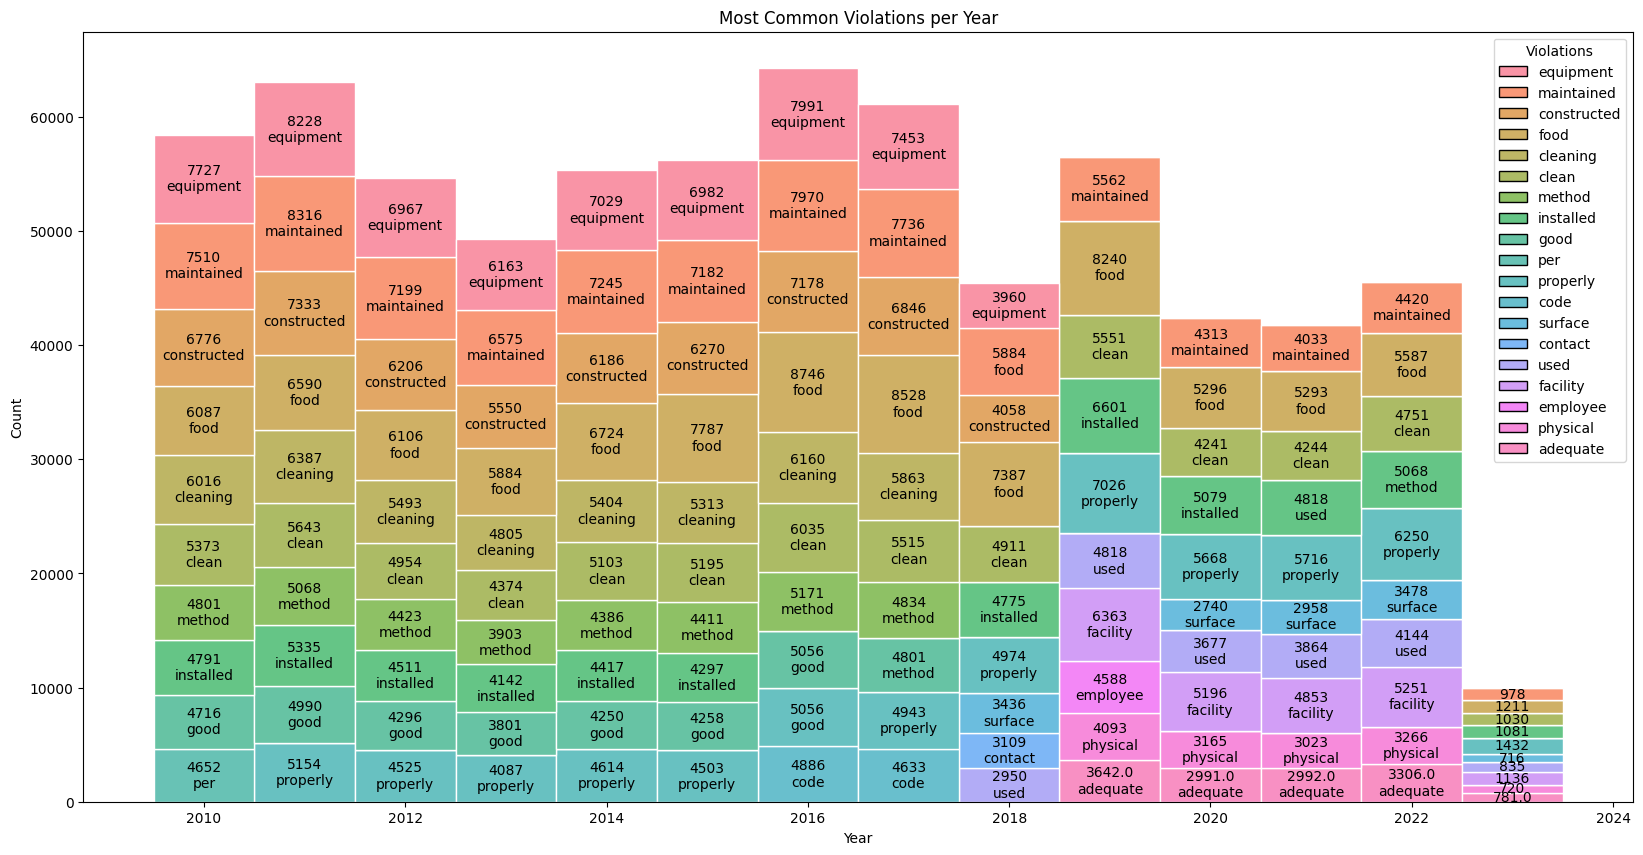

In [223]:
fig,axs = plt.subplots(1,1,figsize=(20,10))
stacked_plot = sns.histplot(data=sorted_selected, x='Year', hue='Violations', weights='Count', discrete=True, multiple='stack')
axs.set(title="Most Common Violations per Year")
for c in stacked_plot.containers:
    labels = [str(v.get_height()) +"\n" + str(sorted_selected[sorted_selected['Count']==v.get_height()].iloc[0,1]) if (v.get_height() > 0) & (v.get_height()>2000) else v.get_height() if v.get_height()>0 else '' for v in c]
    stacked_plot.bar_label(c, labels=labels, label_type='center',color='black')
for patch in axs.patches:
    patch.set_edgecolor("#FFFFFF")

# This is the Polars Implementation.
## Run this if you want to run the code faster.

In [166]:
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk as nltk
import nltk.corpus  
import warnings
warnings.filterwarnings("ignore")
stopwords = set(nltk.corpus.stopwords.words('english'))

### Reading the Data

In [167]:
food_inspection_pl = pl.read_csv("../data/Food_Inspections.csv")
food_inspection_pl.head()

Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
i64,str,str,i64,str,str,str,str,str,i64,str,str,str,str,f64,f64,str
2563767,"""CERES' TABLE""","""CERES' TABLE""",2137239,"""Restaurant""","""Risk 1 (High)""","""3124 N BROADWA...","""CHICAGO""","""IL""",60657,"""09/15/2022""","""Non-Inspection...","""No Entry""",null,41.938412,-87.644492,"""(41.9384119716..."
2563480,"""FINKI ELEMENTA...","""FINKI ELEMENTA...",23541,"""School""","""Risk 1 (High)""","""2332 S Western...","""CHICAGO""","""IL""",60608,"""09/12/2022""","""Canvass""","""Pass""",null,null,null,null
2563279,"""SH GRILL""","""SH GRILL""",2863054,"""Catering""","""Risk 1 (High)""","""167 N GREEN ST...","""CHICAGO""","""IL""",60607,"""09/06/2022""","""License""","""Pass""",null,41.885044,-87.648476,"""(41.8850441766..."
2562053,"""SUBWAY""","""SUBWAY""",2863267,"""Restaurant""","""Risk 1 (High)""","""4351 W ARMITAG...","""CHICAGO""","""IL""",60639,"""08/12/2022""","""License""","""Pass""",null,41.916939,-87.735947,"""(41.9169392924..."
2560592,"""PROVARE CHICAG...","""PROVARE CHICAG...",2796734,"""Restaurant""","""Risk 1 (High)""","""1421 W CHICAGO...","""CHICAGO""","""IL""",60642,"""07/12/2022""","""Canvass""","""Pass""",null,41.896025,-87.663272,"""(41.8960250270..."


### Filtering for Failed data and removing all nans from Violations

In [168]:
failed_inspection_pl = food_inspection_pl.filter((pl.col("Results")=="Fail") & (pl.col("Violations").is_not_null()))
failed_inspection_pl.head()

Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
i64,str,str,i64,str,str,str,str,str,i64,str,str,str,str,f64,f64,str
2544891,"""NEW FURAMA RES...","""NEW FURAMA SEA...",29331,"""Restaurant""","""Risk 1 (High)""","""2828 S WENTWOR...","""CHICAGO""","""IL""",60616,"""12/01/2021""","""Complaint""","""Fail""","""3. MANAGEMENT,...",41.841723,-87.631918,"""(41.8417228243..."
2534457,"""YOLK CAFE""","""YOLK CAFE""",2298934,"""Restaurant""","""Risk 1 (High)""","""500 W MADISON ...","""CHICAGO""","""IL""",60661,"""10/07/2021""","""Canvass""","""Fail""","""3. MANAGEMENT,...",41.881994,-87.639759,"""(41.8819943382..."
2531243,"""Farm Super Mar...","""Farm Super Mar...",2017764,"""Grocery Store""","""Risk 2 (Medium...","""2255-2257 W De...","""CHICAGO""","""IL""",60659,"""09/10/2021""","""Complaint Re-I...","""Fail""","""6. PROPER EATI...",41.997668,-87.687147,"""(41.9976681840..."
2528631,"""SLIMS""","""SLIMS""",2732608,"""Restaurant""","""Risk 1 (High)""","""2020 W MONTROS...","""CHICAGO""","""IL""",60618,"""08/26/2021""","""Canvass""","""Fail""","""3. MANAGEMENT,...",41.961556,-87.679862,"""(41.9615557912..."
2528618,"""GO FISH GROUP ...","""GO FISH""",2757989,"""Restaurant""","""Risk 2 (Medium...","""3022 W MADISON...","""CHICAGO""","""IL""",60612,"""08/26/2021""","""Complaint""","""Fail""","""1. PERSON IN C...",41.881126,-87.702237,"""(41.8811264745..."


### Extracting the code, comment and the description from a Violation

In [169]:
def pl_extract_descriptions(violation_dict):
    violation = violation_dict["Violations"]
    split_violations = violation.split(sep=" | ")
    regex_values = []
    pattern = r"(?<=\d\.).*(?= - Comments)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.append(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    return regex_values
def pl_extract_code(violation_dict):
    violation = violation_dict["Violations"]
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(\d{1,2}\. )"
    for i in split_violations:
        regex = re.search(pattern,i)
        string = i[regex.start(0):regex.end(0)].strip()
        regex_values.append(string)
    return regex_values
def pl_extract_comments(violation_dict):
    violation = violation_dict["Violations"]
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(?<= - Comments: ).*"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            continue
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    return regex_values 

In [170]:
failed_inspection_pl = failed_inspection_pl.with_column(
    (
        pl.struct(["Violations"]).apply(pl_extract_code)
    ).alias("violation_codes")
)

failed_inspection_pl = failed_inspection_pl.with_column(
    (
        pl.struct(["Violations"]).apply(pl_extract_descriptions)
    ).alias("violation_descriptions")
)

failed_inspection_pl = failed_inspection_pl.with_column(
    (
        pl.struct(["Violations"]).apply(pl_extract_comments)
    ).alias("violation_comments")
)

In [171]:
failed_inspection_pl.head(1)

Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,violation_codes,violation_descriptions,violation_comments
i64,str,str,i64,str,str,str,str,str,i64,str,str,str,str,f64,f64,str,list[str],list[str],list[str]
2544891,"""NEW FURAMA RES...","""NEW FURAMA SEA...",29331,"""Restaurant""","""Risk 1 (High)""","""2828 S WENTWOR...","""CHICAGO""","""IL""",60616,"""12/01/2021""","""Complaint""","""Fail""","""3. MANAGEMENT,...",41.841723,-87.631918,"""(41.8417228243...","[""3."", ""5."", … ""58.""]","[""MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING"", ""PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS"", … ""ALLERGEN TRAINING AS REQUIRED""]","[""2-102.14(O) OBSERVED NO EMPLOYEE HEALTH POLICY ON SITE. INSTRUCTED TO PROVIDE. PRIORITY FOUNDATION 7-38-010."", ""2-501.11 OBSERVED NO WRITTEN PROCEDURE NOR ADEQUATE SUPPLIES ON SITE TO PROPERLY RESPOND TO VOMIT AND DIARRHEA EVENTS THAT CAN POTENTIALLY OCCUR INSIDE OF THE FACILITY. INSTRUCTED TO PROVIDE. PRIORITY FOUNDATION 7-38-005."", … ""2-102.13 OBSERVED THE CITY OF CHICAGO FOOD SERVICE SANITATION MANAGERS WITHOUT THE REQUIRED ALLERGEN TRAINING. INSTRUCTED TO MEET REQUIREMENTS.""]"


### Exploding the resultant lists to create a dataframe of specific violations

In [172]:
descriptions_pl = failed_inspection_pl.explode("violation_descriptions")[["violation_descriptions"]]
comments_pl = failed_inspection_pl.explode(["violation_comments"])[["violation_comments"]]

### Filtering for nan values

In [173]:
descriptions_pl = descriptions_pl.filter((pl.col("violation_descriptions").is_not_null()))
comments_pl = comments_pl.filter((pl.col("violation_comments").is_not_null()))

### Tokenizing the Descriptions and Comments

In [174]:
descriptions_noediting_pl = descriptions_pl.with_column(
    (
        pl.struct(["violation_descriptions"]).apply(lambda x: nltk.tokenize.word_tokenize(x['violation_descriptions']))
    )
)

comments_noediting_pl = comments_pl.with_column(
    (
        pl.struct(["violation_comments"]).apply(lambda x: nltk.tokenize.word_tokenize(x['violation_comments']))
    )
)

### Exploding them to get all tokens as individual rows

In [175]:
descriptions_noediting_pl = descriptions_noediting_pl.explode('violation_descriptions')
comments_noediting_pl = comments_noediting_pl.explode('violation_comments')

### Finding the top 10 comments and desciptions

In [176]:
top10_descriptions_pl = descriptions_noediting_pl['violation_descriptions'].value_counts(sort=True)[:10]
top10_comments_pl = comments_noediting_pl['violation_comments'].value_counts(sort=True)[:10]

In [177]:
top10_descriptions_pl

violation_descriptions,counts
str,u32
""",""",357589
"""AND""",169521
""":""",126080
"""MAINTAINED""",84923
"""FOOD""",84210
"""PROPERLY""",68545
"""CLEAN""",66920
"""&""",66745
"""CONSTRUCTED""",66183


In [178]:
top10_comments_pl

violation_comments,counts
str,u32
""".""",683000
"""AND""",347893
""",""",340340
"""THE""",255757
"""IN""",232456
"""TO""",219466
"""OF""",148369
"""MUST""",142590
"""ON""",130234


### Creating a function to clean the descriptions and comments

In [179]:
def clean_pl(dicts):
    string = list(dicts.values())[0]
    words = nltk.tokenize.word_tokenize(string)
    words = [word for word in words if len(word) > 1]
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words]
    words = [word for word in words if word not in stopwords]
    words = [word for word in words if word != "comments"]
    return words

In [180]:
descriptions_editing_pl = descriptions_pl.with_column(
    (
        pl.struct(["violation_descriptions"]).apply(clean_pl)
    )
)

comments_editing_pl = comments_pl.with_column(
    (
        pl.struct(["violation_comments"]).apply(clean_pl)
    )
)

### Exploding the cleaned descriptions and comments and getting the top 10

In [181]:
descriptions_editing_pl = descriptions_editing_pl.explode('violation_descriptions')
descriptions_editing_pl = descriptions_editing_pl.filter((pl.col("violation_descriptions").is_not_null()))

comments_editing_pl = comments_editing_pl.explode('violation_comments')
comments_editing_pl = comments_editing_pl.filter((pl.col("violation_comments").is_not_null()))

In [182]:
top10_clean_descriptions_pl = descriptions_editing_pl["violation_descriptions"].value_counts(sort=True)[:10]
top10_clean_comments_pl = comments_editing_pl['violation_comments'].value_counts(sort=True)[:10]

In [183]:
top10_clean_descriptions_pl

violation_descriptions,counts
str,u32
"""maintained""",84923
"""food""",84210
"""properly""",68545
"""clean""",66920
"""constructed""",66183
"""equipment""",64410
"""installed""",64370
"""cleaning""",48295
"""surfaces""",48204


In [184]:
top10_clean_comments_pl

violation_comments,counts
str,u32
"""must""",152065
"""food""",125855
"""instructed""",124042
"""observed""",112296
"""clean""",108918
"""area""",99109
"""maintain""",82212
"""prep""",79553
"""sink""",79491


### Creating a porter stemmer and applying it over the cleaned tokens and then finding the top 10

In [185]:
porter = nltk.PorterStemmer()

In [186]:
descriptions_editing_porter_pl = descriptions_editing_pl.with_column(
    (
        pl.struct(["violation_descriptions"]).apply(lambda x: porter.stem(x['violation_descriptions']))
    )
)

comments_editing_porter_pl = comments_editing_pl.with_column(
    (
        pl.struct(["violation_comments"]).apply(lambda x: porter.stem(x['violation_comments']))
    )
)

In [187]:
top10_porter_descriptions_pl = descriptions_editing_porter_pl["violation_descriptions"].value_counts(sort=True)[:10]
top10_porter_comments_pl = comments_editing_porter_pl['violation_comments'].value_counts(sort=True)[:10]

In [188]:
top10_porter_descriptions_pl

violation_descriptions,counts
str,u32
"""clean""",141214
"""food""",89466
"""maintain""",88472
"""properli""",68545
"""construct""",66183
"""equip""",64410
"""instal""",64370
"""surfac""",48204
"""contact""",45212


In [189]:
top10_porter_comments_pl

violation_comments,counts
str,u32
"""must""",152070
"""food""",149559
"""area""",136088
"""clean""",135449
"""instruct""",124223
"""observ""",112738
"""sink""",94874
"""maintain""",92657
"""floor""",88621


### Creating a Lancaster stemmer and applying it over the cleaned tokens and then finding the top 10

In [190]:
lancaster = nltk.LancasterStemmer()

In [191]:
descriptions_editing_lancaster_pl = descriptions_editing_pl.with_column(
    (
        pl.struct(["violation_descriptions"]).apply(lambda x: lancaster.stem(x['violation_descriptions']))
    )
)

comments_editing_lancaster_pl = comments_editing_pl.with_column(
    (
        pl.struct(["violation_comments"]).apply(lambda x: lancaster.stem(x['violation_comments']))
    )
)

In [192]:
top10_lancaster_descriptions_pl = descriptions_editing_lancaster_pl["violation_descriptions"].value_counts(sort=True)[:10]
top10_lancaster_comments_pl = comments_editing_lancaster_pl['violation_comments'].value_counts(sort=True)[:10]

In [193]:
top10_lancaster_descriptions_pl

violation_descriptions,counts
str,u32
"""cle""",149018
"""food""",89466
"""maintain""",88472
"""prop""",84837
"""construct""",66183
"""equip""",64410
"""instal""",64370
"""surfac""",48204
"""contact""",45212


In [194]:
top10_lancaster_comments_pl

violation_comments,counts
str,u32
"""must""",152072
"""food""",149560
"""cle""",147493
"""instruct""",124252
"""observ""",112737
"""are""",99109
"""prep""",96862
"""sink""",94876
"""stor""",93797


### Creating a Lemmatizer and applying it over the cleaned tokens and then finding the top 10

In [195]:
wnl = nltk.WordNetLemmatizer()

In [196]:
descriptions_editing_lemmatize_pl = descriptions_editing_pl.with_column(
    (
        pl.struct(["violation_descriptions"]).apply(lambda x: wnl.lemmatize(x['violation_descriptions']))
    )
)

comments_editing_lemmatize_pl = comments_editing_pl.with_column(
    (
        pl.struct(["violation_comments"]).apply(lambda x: wnl.lemmatize(x['violation_comments']))
    )
)

In [197]:
top10_lemmatize_descriptions_pl = descriptions_editing_lemmatize_pl["violation_descriptions"].value_counts(sort=True)[:10]
top10_lemmatize_comments_pl = comments_editing_lemmatize_pl['violation_comments'].value_counts(sort=True)[:10]

In [198]:
top10_lemmatize_descriptions_pl

violation_descriptions,counts
str,u32
"""food""",89466
"""maintained""",84923
"""properly""",68545
"""clean""",66920
"""constructed""",66183
"""equipment""",64410
"""installed""",64370
"""cleaning""",48295
"""surface""",48204


In [199]:
top10_lemmatize_comments_pl

violation_comments,counts
str,u32
"""must""",152069
"""food""",149558
"""area""",136089
"""instructed""",124042
"""observed""",112296
"""clean""",108923
"""sink""",94873
"""floor""",88269
"""maintain""",82212


Looking at the comparisions, we can see that the Lemmatizer had the most comprehensive collection of words. In the lancaster stemming, words like area and are were confused, while in porter stemming, the loss of the stem, makes it difficult to understand what the words was. The Lemmatizer has in comparision maintained the characteristic of the words, thus making it easier to understand.

## Looking at the top 10 words per year 

### Lets get the violations and the inspection date

In [208]:
violations_over_time_pl = failed_inspection_pl[["Violations","Inspection Date"]]
violations_over_time_pl.head()

Violations,Inspection Date
str,str
"""3. MANAGEMENT,...","""12/01/2021"""
"""3. MANAGEMENT,...","""10/07/2021"""
"""6. PROPER EATI...","""09/10/2021"""
"""3. MANAGEMENT,...","""08/26/2021"""
"""1. PERSON IN C...","""08/26/2021"""


### Clean the violations and lemmatize it

In [209]:
violations_over_time_pl = violations_over_time_pl.with_column(
    (
        pl.struct(["Violations"]).apply(pl_extract_descriptions)
    )
)
violations_over_time_pl = violations_over_time_pl.explode("Violations")
violations_over_time_pl = violations_over_time_pl.with_column(
    (
        pl.struct(["Violations"]).apply(clean_pl)
    )
)
violations_over_time_pl = violations_over_time_pl.explode("Violations")
violations_over_time_pl.head()

Violations,Inspection Date
str,str
"""management""","""12/01/2021"""
"""food""","""12/01/2021"""
"""employee""","""12/01/2021"""
"""conditional""","""12/01/2021"""
"""employee""","""12/01/2021"""


In [210]:
violations_over_time_pl = violations_over_time_pl.filter((pl.col("Violations").is_not_null()))
violations_over_time_pl = violations_over_time_pl.with_column(
    (
        pl.struct(["Violations"]).apply(lambda x: wnl.lemmatize(x['Violations']))
    )
)

violations_over_time_pl.head()

Violations,Inspection Date
str,str
"""management""","""12/01/2021"""
"""food""","""12/01/2021"""
"""employee""","""12/01/2021"""
"""conditional""","""12/01/2021"""
"""employee""","""12/01/2021"""


### Extract the year from the Violations. We aren't doing Month/Year as there are too many columns

In [212]:
violations_over_time_pl = violations_over_time_pl.with_column(
    (
        pl.col('Inspection Date').str.strptime(pl.Date, fmt='%m/%d/%Y').cast(pl.Datetime)
    )
)
violations_over_time_pl = violations_over_time_pl.with_column(
    (
        pl.col("Inspection Date").dt.strftime("%Y").alias("Year")
    )
)
violations_over_time_pl = violations_over_time_pl.drop("Inspection Date")
violations_over_time_pl.head()

Violations,Year
str,str
"""management""","""2021"""
"""food""","""2021"""
"""employee""","""2021"""
"""conditional""","""2021"""
"""employee""","""2021"""


### Group by the Year and the violations and get the counts and then select the top 10 violations per year

In [213]:
violations_agg = violations_over_time_pl.groupby(["Year","Violations"]).count()

In [214]:
sorted_selected_pl = violations_agg.groupby('Year').agg(pl.col('Violations').sort_by('count',descending=True).slice(0,10))
sorted_selected_pl = sorted_selected_pl.explode("Violations")
sorted_selected_pl = sorted_selected_pl.join(violations_agg,on=["Year","Violations"],how='left')

In [215]:
sorted_selected_pl = sorted_selected_pl.sort('Year')

### Visualize it

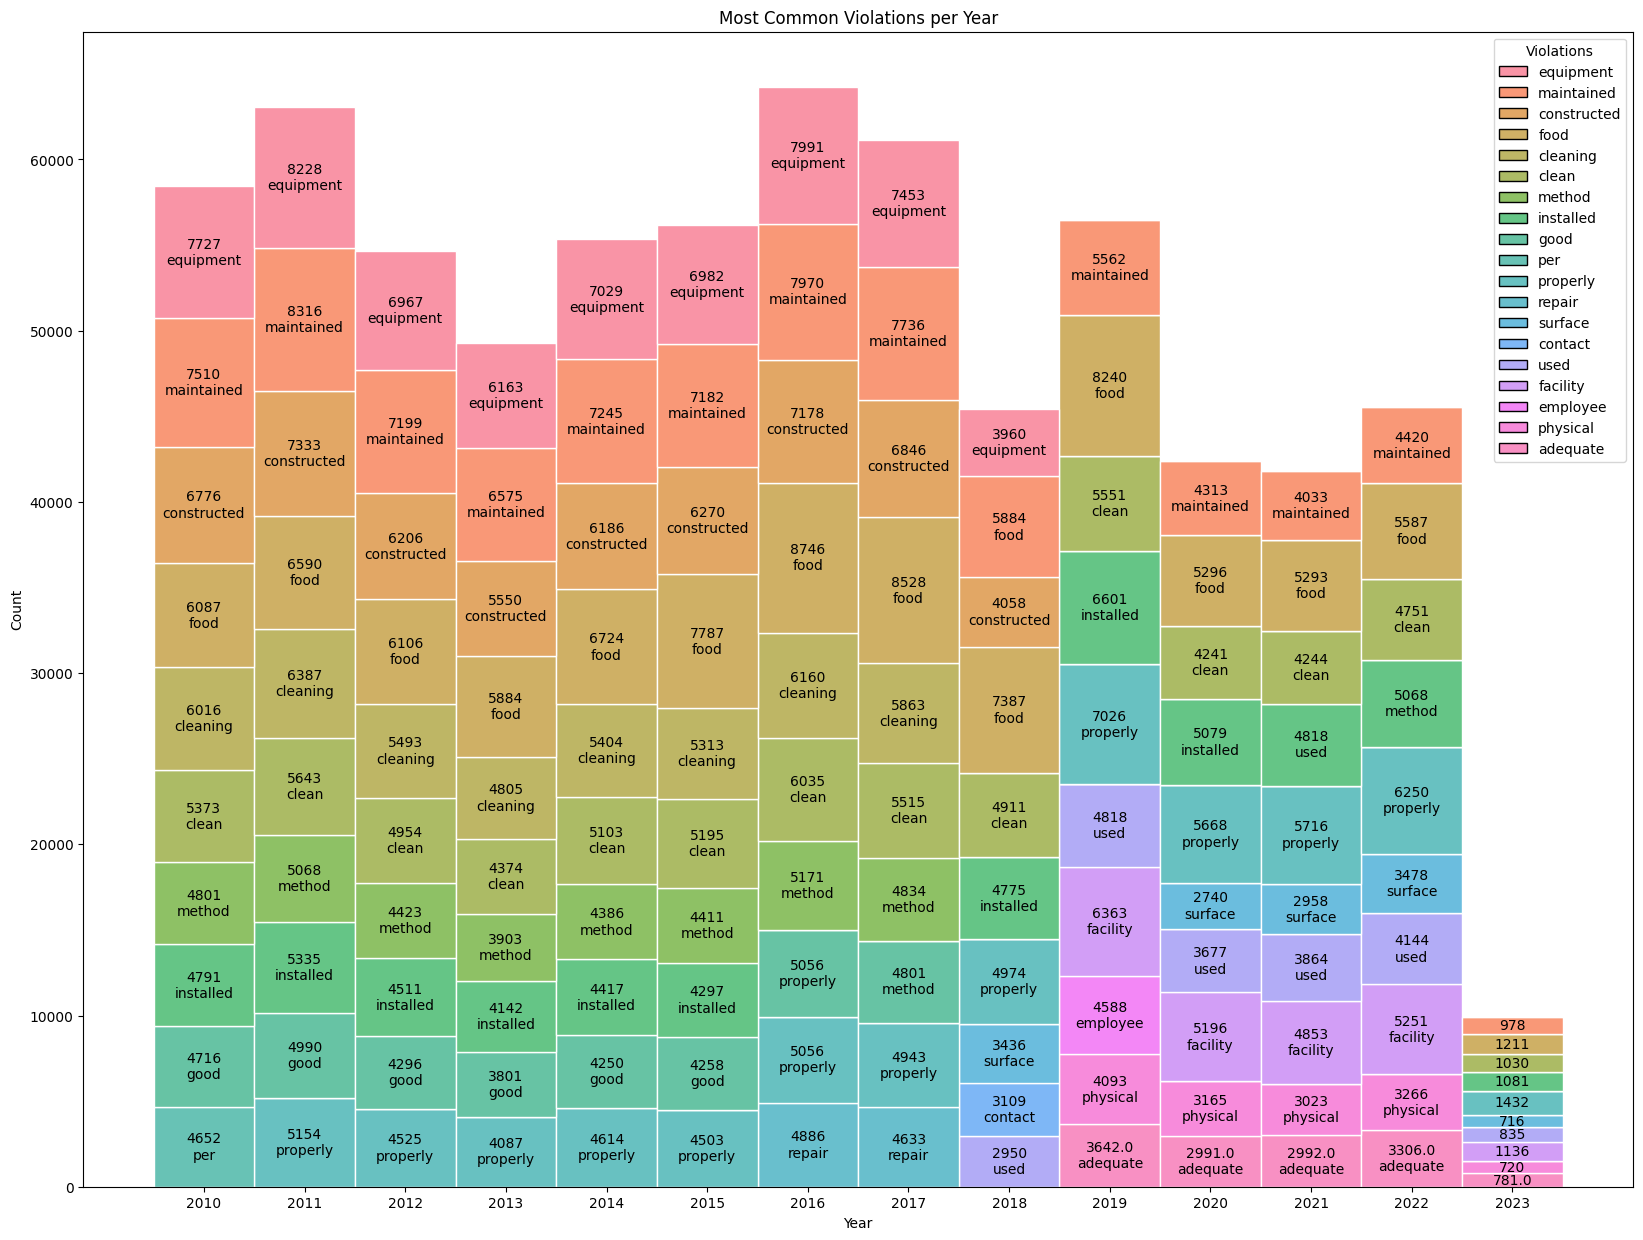

In [217]:
fig,axs = plt.subplots(1,1,figsize=(20,15))
stacked_plot_pl = sns.histplot(data=sorted_selected_pl, x='Year', hue='Violations', weights='count', discrete=True, multiple='stack',ax=axs)
axs.set(title="Most Common Violations per Year")
for c in stacked_plot_pl.containers:
    labels = [str(v.get_height()) +"\n" + sorted_selected_pl.filter(pl.col('count')==v.get_height())[0,1] if (v.get_height() > 0) & (v.get_height()>2000) else v.get_height() if v.get_height()>0 else '' for v in c]
    stacked_plot_pl.bar_label(c, labels=labels, label_type='center',color='black')
for patch in axs.patches:
    patch.set_edgecolor("#FFFFFF")